In [88]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf

In [89]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from  tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import shutil
import time
#import torch
#import cv2 as cv2
#from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
#from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
from sklearn.metrics import confusion_matrix
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler

In [90]:
c=0
for filename in os.listdir("../archive/images"):
    if filename.endswith(".jpg"):
        c+=1    
print(c)


10015


In [91]:
groundTruth = pd.read_csv('../archive/GroundTruth.csv')

In [92]:
groundTruth

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Check to see if the categories are mutually exclusive
sumRows = groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=1) 
#Add up each row. If mutually exclusive sum of each row should be 1

print(sumRows.sum(axis=0))
print(len(sumRows))

10015.0
10015


In [95]:
#TRY OVER SAMPLING OTHER LABELS AND UNDER SAMPLING THE NV

#First, add a new column to make over/undersampling easier

def defineLabel(row):
    if row['MEL'] == 1:
        val = "MEL"
    elif row['NV'] ==1:
        val = 'NV'
    elif row['BCC'] ==1:
        val = 'BCC'
    elif row['AKIEC'] ==1:
        val = 'AKIEC'
    elif row['BKL'] ==1:
        val = 'BKL'
    elif row['DF'] ==1:
        val = 'DF'
    else:
        val = 'VASC'
    return val

groundTruth['label'] = groundTruth.apply(defineLabel, axis=1)


In [96]:
groundTruth

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV


In [97]:
sumColumns = pd.DataFrame(groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(groundTruth)

In [98]:
sumColumns
#Very skewed data. Will need to do imbalence technique

,Total,Percent Total
MEL,1113.0,0.111133
NV,6705.0,0.669496
BCC,514.0,0.051323
AKIEC,327.0,0.032651
BKL,1099.0,0.109735
DF,115.0,0.011483
VASC,142.0,0.014179


In [99]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(groundTruth, groundTruth["label"])
# print(sorted(Counter(y_resampled).items()))

In [100]:
X_resampled = X_resampled.drop(columns="label")

In [101]:
sumColumns = pd.DataFrame(X_resampled[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(groundTruth)
sumColumns

,Total,Percent Total
MEL,115.0,0.011483
NV,115.0,0.011483
BCC,115.0,0.011483
AKIEC,115.0,0.011483
BKL,115.0,0.011483
DF,115.0,0.011483
VASC,115.0,0.011483


In [102]:
#The trainingDf is 70% of the data
#The workingTesting and validationTesting (final validation set) are 15% the data eatch

trainingDf, testingDf  = train_test_split(X_resampled, test_size=0.3, random_state=42, stratify = X_resampled[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])
workingTesting, validationTesting = train_test_split(testingDf, test_size=0.5, random_state=42, stratify = testingDf[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])







In [87]:
# #CSVs for Nidhi
# trainingDf.to_csv('trainingDf.csv')
# testingDf.to_csv('testingDf.csv')

In [107]:
trainingDf

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
483,ISIC_0033424,1.0,0.0,0.0,0.0,0.0,0.0,0.0
542,ISIC_0025363,1.0,0.0,0.0,0.0,0.0,0.0,0.0
633,ISIC_0025027,0.0,1.0,0.0,0.0,0.0,0.0,0.0
93,ISIC_0024913,0.0,0.0,0.0,1.0,0.0,0.0,0.0
587,ISIC_0028235,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
383,ISIC_0027613,0.0,0.0,0.0,0.0,0.0,1.0,0.0
771,ISIC_0029448,0.0,0.0,0.0,0.0,0.0,0.0,1.0
452,ISIC_0033790,0.0,0.0,0.0,0.0,0.0,1.0,0.0
544,ISIC_0024853,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
# Double check to see if stratification worked on the train set
trainSumColumns = pd.DataFrame(trainingDf[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
trainSumColumns = trainSumColumns.rename(columns={0: "Total"})
trainSumColumns['Percent Total'] = trainSumColumns['Total'] / len(trainingDf)
trainSumColumns

,Total,Percent Total
MEL,80.0,0.142096
NV,81.0,0.143872
BCC,80.0,0.142096
AKIEC,80.0,0.142096
BKL,80.0,0.142096
DF,81.0,0.143872
VASC,81.0,0.143872


In [109]:
# Double check to see if stratification worked on the test set
testSumColumns = pd.DataFrame(testingDf[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
testSumColumns = testSumColumns.rename(columns={0: "Total"})
testSumColumns['Percent Total'] = testSumColumns['Total'] / len(testingDf)
testSumColumns

,Total,Percent Total
MEL,35.0,0.144628
NV,34.0,0.140496
BCC,35.0,0.144628
AKIEC,35.0,0.144628
BKL,35.0,0.144628
DF,34.0,0.140496
VASC,34.0,0.140496


In [102]:
# trainingDf = trainingDf[["image", "NV"]]
# testingDf = testingDf[["image", "NV"]]

In [66]:
#Just a simple test data set for setting up the models
train = trainingDf.iloc[1:15,:]
test = testingDf.iloc[1:10,:]

In [110]:
#TRAINGING PROCESSING


x_data_train = []

for i in trainingDf.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)

    x_data_train.append(input_arr)
    


In [111]:
#TESTING PROCESSING

x_data_test = []

for i in workingTesting.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)

    x_data_test.append(input_arr)

In [112]:
#VALIDATION PROCESSING

x_data_validation = []

for i in validationTesting.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)

    x_data_validation.append(input_arr)

In [115]:


#Get y_train-Data ready for model
y_train_final = np.asarray(trainingDf.loc[:, trainingDf.columns != 'image'])
print(y_train_final.shape)

#Get y_test-Data ready for model
y_test_final = np.asarray(workingTesting.loc[:, workingTesting.columns != 'image'])
print(y_test_final.shape)

#Get y_val-Data ready for model
y_val_final = np.asarray(validationTesting.loc[:, validationTesting.columns != 'image'])
print(y_val_final.shape)



#Get x_Data train ready for model
x_train_final = np.asarray(x_data_train).astype('float32') / 255.
print(x_train_final.shape)

#Get x_Data test ready for model
x_test_final = np.asarray(x_data_test).astype('float32') / 255.
print(x_test_final.shape)

#Get x_Data validation 
x_val_final = np.asarray(x_data_validation).astype('float32') / 255.
print(x_val_final.shape) #x_train




(563, 7)
(121, 7)
(121, 7)
(563, 450, 600, 3)
(121, 450, 600, 3)
(121, 450, 600, 3)


In [117]:
#Start Building model

shape = x_data_train[0].shape

In [118]:
# Simple dummy model
def buildModel():
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(7, activation="softmax"))
    return model
    


In [119]:
m = buildModel()
m.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 446, 596, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 442, 592, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 221, 296, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 221, 296, 32)      0         
                                                                 
 flatten_4 (Flatten)         (None, 2093312)           0         
                                                                 
 dense_34 (Dense)            (None, 256)               535888128 
                                                     

In [122]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
m.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [123]:
# from sklearn.model_selection import RandomizedSearchCV

# wrap_model = keras.wrappers.scikit_learn.KerasClassifier(buildModel)

# params = {
#     "epochs": [5, 10],
#     "batch_size": [5, 10,25, 50,100]   
# }

# rnd_search_cv = RandomizedSearchCV(wrap_model, params, n_iter=5, cv=3)
# rnd_search_cv.fit(X = x_data_final, y = y_train_final)

In [126]:
#epochs = 15
history = m.fit(x_train_final, y_train_final, epochs=5, batch_size=64)

#look for keras tunner

Epoch 1/5
9/9 [==============================] - 669s 70s/step - loss: nan - accuracy: 0.1421
Epoch 2/5
9/9 [==============================] - 613s 69s/step - loss: nan - accuracy: 0.1421
Epoch 3/5
9/9 [==============================] - 553s 60s/step - loss: nan - accuracy: 0.1421
Epoch 4/5
9/9 [==============================] - 459s 51s/step - loss: nan - accuracy: 0.1421
Epoch 5/5
9/9 [==============================] - 460s 51s/step - loss: nan - accuracy: 0.1421


In [130]:
x_train_final.shape

(563, 450, 600, 3)

In [127]:
m.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [128]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 9}

In [125]:
x_train_final

array([[[[0.58431375, 0.5372549 , 0.5921569 ],
         [0.6       , 0.5411765 , 0.6156863 ],
         [0.59607846, 0.54509807, 0.62352943],
         ...,
         [0.627451  , 0.5254902 , 0.6392157 ],
         [0.62352943, 0.5254902 , 0.6392157 ],
         [0.61960787, 0.5294118 , 0.6392157 ]],

        [[0.5882353 , 0.5411765 , 0.5882353 ],
         [0.59607846, 0.54509807, 0.6117647 ],
         [0.58431375, 0.54901963, 0.62352943],
         ...,
         [0.6313726 , 0.5294118 , 0.63529414],
         [0.627451  , 0.5254902 , 0.6392157 ],
         [0.627451  , 0.5254902 , 0.6392157 ]],

        [[0.5764706 , 0.5372549 , 0.5803922 ],
         [0.58431375, 0.5529412 , 0.6039216 ],
         [0.58431375, 0.56078434, 0.6156863 ],
         ...,
         [0.63529414, 0.5294118 , 0.65882355],
         [0.6313726 , 0.5254902 , 0.6627451 ],
         [0.6392157 , 0.5294118 , 0.6784314 ]],

        ...,

        [[0.61960787, 0.57254905, 0.57254905],
         [0.63529414, 0.57254905, 0.58431375]

In [129]:
XTEST = []


#Process all the images in the training data set.
for i in x_data_test.iloc[:,0]: #FIXME CHANGE BACK TO TRAINING DF
    path="../archive/images/" + i + ".jpg"
    
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)

    XTEST.append(input_arr)
    



AttributeError: 'list' object has no attribute 'iloc'

In [65]:
#Get y-Data ready for model
YTEST = np.asarray(test1.loc[:, trainingDf.columns != 'image'])
# y_train_final = np.asarray(trainingDf.loc[:, test.columns != 'image'])
print(YTEST.shape)


#Get x_Data ready for model
XTEST = np.asarray(XTEST).astype('float32') / 255.
print(XTEST.shape) #x_train



(557, 7)
(557, 450, 600, 3)


In [66]:
predictions = m.predict(XTEST)



In [67]:
y_pred = m.predict(XTEST)
y_pred = np.argmax(y_pred, axis=1)





In [68]:
y_pred

array([2, 4, 4, 5, 1, 0, 5, 4, 2, 0, 5, 2, 1, 2, 5, 0, 6, 1, 0, 0, 6, 1,
       5, 3, 0, 2, 1, 1, 4, 4, 5, 1, 3, 3, 3, 6, 0, 2, 6, 4, 1, 2, 4, 6,
       4, 1, 2, 0, 5, 1, 2, 5, 1, 3, 2, 6, 2, 6, 6, 3, 5, 2, 3, 5, 3, 2,
       6, 0, 2, 5, 6, 5, 3, 3, 0, 4, 6, 4, 1, 0, 1, 3, 0, 1, 2, 3, 3, 1,
       1, 6, 5, 6, 0, 6, 4, 5, 4, 6, 0, 3, 2, 1, 0, 3, 3, 1, 4, 2, 3, 1,
       3, 0, 0, 5, 4, 5, 1, 4, 6, 0, 5, 5, 5, 6, 3, 5, 2, 2, 4, 2, 0, 1,
       1, 0, 5, 4, 0, 4, 1, 4, 6, 6, 6, 1, 3, 6, 2, 2, 1, 0, 3, 3, 4, 2,
       6, 4, 1, 2, 0, 0, 5, 6, 2, 5, 4, 6, 0, 1, 0, 0, 4, 2, 1, 4, 2, 2,
       0, 0, 2, 2, 2, 0, 6, 3, 3, 1, 2, 2, 1, 5, 3, 5, 1, 4, 2, 3, 6, 5,
       3, 4, 2, 3, 2, 3, 1, 0, 6, 3, 6, 3, 6, 3, 6, 2, 1, 4, 2, 4, 6, 3,
       0, 4, 0, 2, 0, 5, 3, 1, 0, 2, 2, 2, 6, 3, 0, 6, 6, 6, 6, 2, 2, 2,
       0, 6, 6, 2, 2, 0, 1, 5, 6, 2, 0, 3, 2, 4, 1, 4, 0, 5, 2, 4, 0, 1,
       2, 4, 6, 0, 4, 1, 3, 0, 6, 5, 1, 5, 4, 2, 3, 5, 4, 2, 4, 3, 6, 1,
       2, 5, 5, 4, 1, 1, 3, 0, 4, 6, 1, 1, 0, 6, 6,

In [121]:
conf_mat = confusion_matrix(YTEST, y_pred)



ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [122]:
YTEST

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
 

### Autoencoder


In [74]:
encoding_dim = 64  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(810000,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(810000, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [75]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [76]:
#This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


In [77]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [78]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 810000)]          0         
                                                                 
 dense_32 (Dense)            (None, 64)                51840064  
                                                                 
 dense_33 (Dense)            (None, 810000)            52650000  
                                                                 
Total params: 104,490,064
Trainable params: 104,490,064
Non-trainable params: 0
_________________________________________________________________


In [79]:
x_train_final_ae = x_train_final.reshape((len(x_train_final), np.prod(x_train_final.shape[1:])))
x_test_final_ae = x_test_final.reshape((len(x_test_final), np.prod(x_test_final.shape[1:])))

In [80]:
x_train_final_ae.shape

(563, 810000)

In [82]:
autoencoder.fit(x_train_final_ae, x_train_final_ae,
                epochs=5,
                batch_size=64,
                shuffle=True,
                verbose = True)
               # validation_data=(x_test_final, x_test_final))

Epoch 1/5
9/9 [==============================] - 52s 4s/step - loss: 0.6930
Epoch 2/5
9/9 [==============================] - 29s 3s/step - loss: 0.6928
Epoch 3/5
9/9 [==============================] - 19s 2s/step - loss: 0.6924
Epoch 4/5
9/9 [==============================] - 18s 2s/step - loss: 0.6921
Epoch 5/5
9/9 [==============================] - 17s 2s/step - loss: 0.6917


In [83]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test_final_ae)
decoded_imgs = decoder.predict(encoded_imgs)


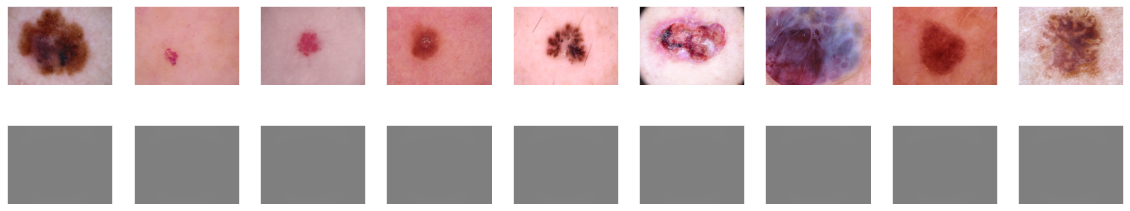

In [85]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 9  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_final_ae[i].reshape(450, 600,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(450, 600,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [86]:
decoded_imgs[0]

array([0.50211823, 0.4997317 , 0.500309  , ..., 0.5017408 , 0.49932164,
       0.49974477], dtype=float32)

### Sparsed Autoencoder

In [64]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [71]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[450, 600, 3]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="selu"),
    keras.layers.Dense(300, activation="selu"),
    keras.layers.Dense(450*600*3, activation="sigmoid"),
    keras.layers.Reshape([450, 600, 3])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer="adam",
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(x_train_final, x_train_final, epochs=5,verbose=True)
                        #  validation_data=(x_test, x_test))

Epoch 1/5
18/18 [==============================] - 74s 3s/step - loss: 0.7547 - rounded_accuracy: 0.7939
Epoch 2/5
18/18 [==============================] - 48s 3s/step - loss: 0.7277 - rounded_accuracy: 0.8404
Epoch 3/5
18/18 [==============================] - 46s 3s/step - loss: 0.7253 - rounded_accuracy: 0.8407
Epoch 4/5
18/18 [==============================] - 53s 3s/step - loss: 0.7243 - rounded_accuracy: 0.8414
Epoch 5/5
18/18 [==============================] - 48s 3s/step - loss: 0.7243 - rounded_accuracy: 0.8412


In [72]:
decoded_imgs = sparse_l1_ae.predict(x_test_final)
decoded_imgs

array([[[[0.59028846, 0.45265147, 0.48210356],
         [0.59872353, 0.45814916, 0.48578125],
         [0.5986793 , 0.46002746, 0.4874867 ],
         ...,
         [0.5806068 , 0.45150584, 0.48080266],
         [0.5770111 , 0.45102322, 0.47632447],
         [0.57727903, 0.44677183, 0.47567108]],

        [[0.5952777 , 0.45608544, 0.48645163],
         [0.6047165 , 0.46373206, 0.49442947],
         [0.6042988 , 0.46345443, 0.49133527],
         ...,
         [0.5900284 , 0.45817268, 0.48562646],
         [0.586561  , 0.45715848, 0.48155928],
         [0.58704877, 0.45471323, 0.48001754]],

        [[0.59681886, 0.45810288, 0.48751062],
         [0.60704327, 0.46393272, 0.49569756],
         [0.6060349 , 0.4625233 , 0.4928879 ],
         ...,
         [0.58949214, 0.4558859 , 0.48240778],
         [0.58820486, 0.4573962 , 0.48332936],
         [0.5874064 , 0.4554514 , 0.48235482]],

        ...,

        [[0.60538286, 0.47308907, 0.5010406 ],
         [0.61596364, 0.47848138, 0.5055336 ]

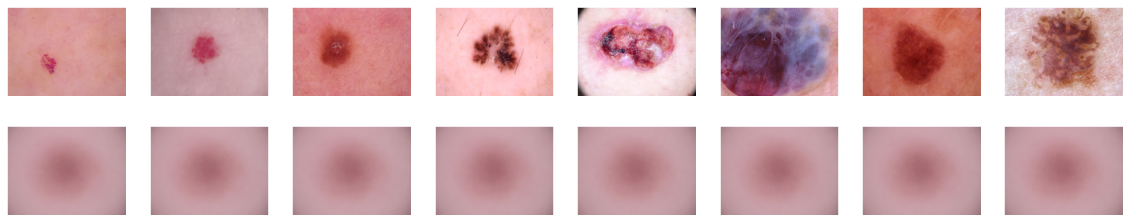

In [73]:
n = 8
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_final[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Autoencoder for denoising.

In [ ]:
x_train_new = x_data_final_train.astype('float32') / 255.
x_test_new = x_data_final_test.astype('float32') / 255.
x_train_new = np.reshape(x_train_new, (len(x_train), 450, 600, 3))
x_test_new = np.reshape(x_test_new, (len(x_test), 450, 600, 3))

noise_factor = 0.5
x_train_noisy = x_train_new + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_new.shape) 
x_test_noisy = x_test_new + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_new.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
x_train_noisy.shape

In [ ]:
x_train_new.shape

In [ ]:
n = 8
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from tensorflow.keras import layers

input_img = keras.Input(shape=(450, 600, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.fit(x_train_noisy, x_train_new,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_new))

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 8
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()